# Regularization

## 1. Introduction

Recall from the last lab that we had a training accuracy close to 90% and a test set accuracy close to 76%.

2 questions:
- Is there a high bias? yes/no
- Is there a high variance? yes/no

Recall that "high bias" is a relative concept. Knowing we have 7 classes and the topics are related, we'll assume that a 90% accuracy is pretty good and the bias on the training set is low. In this lab, we'll use the notion of training/validation/test set to get better insights of how we can mitigate our variance, and we'll look at a few regularization techniques.

Everything in section 2 of this lab is basically what you have done in the previous lab with respect to preprocessing the data. We'll do that again here, and then we'll rerun our model but this time:
- We'll include a validation set as well, and start with using early stopping to minimize the discrepancy between train and test accuracy.
- We'll use L1 and L2 regularization.
- We'll use dropout regularization.
- We'll look at the effect of using more data.

## 2. Pre-processing the bank complaints as in the previous lab

### 2.1 Import the libraries and take a sample

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

df = pd.read_csv('Bank_complaints.csv')
df.head()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


In [2]:
import random
random.seed(123)
df = df.sample(10000)
df.index = range(10000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

There are 7 types of complaints

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Product                         10000 non-null object
Consumer complaint narrative    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


### 2.2 One-hot encoding of the complaints

Only keep 2,000 most common words and use one-hot encoding

In [4]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)

In [5]:
sequences = tokenizer.texts_to_sequences(complaints)

In [6]:
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

(10000, 2000)

### 2.3 One-hot encoding of the products

Use LabelEncoder to encode the labels (From category names to category numbers)

In [7]:
le = preprocessing.LabelEncoder()
le.fit(product)

LabelEncoder()

In [8]:
 list(le.classes_)

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Mortgage',
 'Student loan']

Transform `product` into a numeric vector

In [9]:
product_cat = le.transform(product) 
product_cat

array([6, 6, 6, ..., 5, 5, 2])

Then, use one-hot encoding to get to vectors with 0's and 1's.

In [10]:
product_onehot = to_categorical(product_cat)

In [11]:
product_onehot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [12]:
np.shape(product_onehot)

(10000, 7)

### 2.4 Train - test split

In [13]:
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

In [14]:
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

In [15]:
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

In [16]:
print(np.shape(label_test))
print(np.shape(label_train))
print(np.shape(test))
print(np.shape(train))

(1500, 7)
(8500, 7)
(1500, 2000)
(8500, 2000)


## 3. Running the model using a validation set.

### 3.1 Creating the validation set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

In [17]:
random.seed(123)
val = train[:1000]
train_final = train[1000:]
label_val = label_train[:1000]
label_train_final = label_train[1000:]

### 3.2 Creating, compiling and running the model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.

In [18]:
random.seed(123)
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

We use the same settings as before to compile the model

In [19]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, let's include the argument `validation_data` and assign it `(val, label_val)`

In [20]:
model_val = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 88us/step - loss: 1.9364 - acc: 0.1780 - val_loss: 1.9182 - val_acc: 0.2090
Epoch 2/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.9126 - acc: 0.2057 - val_loss: 1.8981 - val_acc: 0.2140
Epoch 3/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.8921 - acc: 0.2280 - val_loss: 1.8796 - val_acc: 0.2230
Epoch 4/120
7500/7500 [==============================] - 0s 53us/step - loss: 1.8715 - acc: 0.2505 - val_loss: 1.8595 - val_acc: 0.2460
Epoch 5/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.8484 - acc: 0.2739 - val_loss: 1.8363 - val_acc: 0.2690
Epoch 6/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.8212 - acc: 0.3007 - val_loss: 1.8089 - val_acc: 0.2970
Epoch 7/120
7500/7500 [==============================] - 0s 52us/step - loss: 1.7895 - acc: 0.3235 - val_loss: 1.7761 - val_acc: 0.3220


7500/7500 [==============================] - 0s 49us/step - loss: 0.5581 - acc: 0.8096 - val_loss: 0.7152 - val_acc: 0.7400
Epoch 61/120
7500/7500 [==============================] - 0s 52us/step - loss: 0.5533 - acc: 0.8131 - val_loss: 0.7117 - val_acc: 0.7410
Epoch 62/120
7500/7500 [==============================] - 0s 48us/step - loss: 0.5476 - acc: 0.8131 - val_loss: 0.7101 - val_acc: 0.7430
Epoch 63/120
7500/7500 [==============================] - 0s 50us/step - loss: 0.5432 - acc: 0.8161 - val_loss: 0.7087 - val_acc: 0.7360
Epoch 64/120
7500/7500 [==============================] - 0s 52us/step - loss: 0.5377 - acc: 0.8163 - val_loss: 0.7082 - val_acc: 0.7380
Epoch 65/120
7500/7500 [==============================] - 0s 48us/step - loss: 0.5329 - acc: 0.8176 - val_loss: 0.7052 - val_acc: 0.7380
Epoch 66/120
7500/7500 [==============================] - 0s 59us/step - loss: 0.5281 - acc: 0.8204 - val_loss: 0.7049 - val_acc: 0.7420
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 51us/step - loss: 0.3485 - acc: 0.8869 - val_loss: 0.6920 - val_acc: 0.7570


The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [21]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [22]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 59us/step


In [23]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 92us/step


In [24]:
results_train

[0.3456896363099416, 0.8854666666348775]

In [25]:
results_test

[0.6734499278068542, 0.7580000003178914]

Note that the result isn't exactly the same as before. Note that this because the training set is slightly different! We remove 1000 instances for validation!

### Plotting the results

Let's plot the result similarly to what we have done in the previous lab. This time though, let's iclude the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

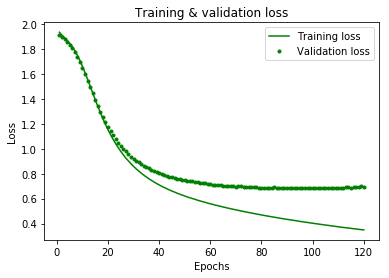

In [26]:
plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

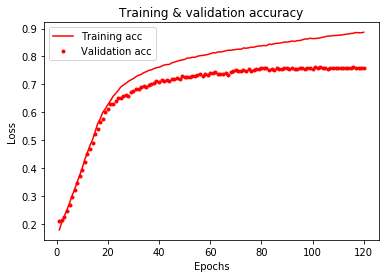

In [27]:
plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 60th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 60th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## 3. Early stopping

In [28]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 1s 77us/step - loss: 1.9515 - acc: 0.1477 - val_loss: 1.9284 - val_acc: 0.1810
Epoch 2/60
7500/7500 [==============================] - 0s 50us/step - loss: 1.9191 - acc: 0.1979 - val_loss: 1.9062 - val_acc: 0.2120
Epoch 3/60
7500/7500 [==============================] - 0s 49us/step - loss: 1.8978 - acc: 0.2332 - val_loss: 1.8878 - val_acc: 0.2360
Epoch 4/60
7500/7500 [==============================] - 0s 51us/step - loss: 1.8785 - acc: 0.2696 - val_loss: 1.8692 - val_acc: 0.2620
Epoch 5/60
7500/7500 [==============================] - 0s 50us/step - loss: 1.8576 - acc: 0.2947 - val_loss: 1.8477 - val_acc: 0.2900
Epoch 6/60
7500/7500 [==============================] - 0s 50us/step - loss: 1.8336 - acc: 0.3196 - val_loss: 1.8223 - val_acc: 0.3300
Epoch 7/60
7500/7500 [==============================] - 0s 52us/step - loss: 1.8053 - acc: 0.3455 - val_loss: 1.7924 - val_acc: 0.3530
Epoch 8

7500/7500 [==============================] - 0s 48us/step - loss: 0.5647 - acc: 0.8028 - val_loss: 0.7200 - val_acc: 0.7280


Now, you can use the test set to make label predictions

In [29]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 57us/step


In [30]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 56us/step


In [31]:
results_train

[0.5598031632741293, 0.8033333333333333]

In [32]:
results_test

[0.712485365708669, 0.7333333328564962]

We've significantly reduced the variance, so this is already pretty good! Our test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs one we fitted before.

Now, let's see what else we can do to improve the result!

## 4. L2 regularization

Let's include L2 regularization. You can easily do this in keras adding the argument kernel_regulizers.l2 and adding a value for the regularization parameter lambda between parentheses.

In [33]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 88us/step - loss: 2.5934 - acc: 0.1533 - val_loss: 2.5741 - val_acc: 0.1650
Epoch 2/120
7500/7500 [==============================] - 0s 52us/step - loss: 2.5615 - acc: 0.1963 - val_loss: 2.5427 - val_acc: 0.2340
Epoch 3/120
7500/7500 [==============================] - 0s 50us/step - loss: 2.5307 - acc: 0.2448 - val_loss: 2.5097 - val_acc: 0.2770
Epoch 4/120
7500/7500 [==============================] - 0s 53us/step - loss: 2.4958 - acc: 0.2868 - val_loss: 2.4717 - val_acc: 0.3010
Epoch 5/120
7500/7500 [==============================] - 0s 52us/step - loss: 2.4551 - acc: 0.3183 - val_loss: 2.4279 - val_acc: 0.3270
Epoch 6/120
7500/7500 [==============================] - 0s 50us/step - loss: 2.4095 - acc: 0.3489 - val_loss: 2.3788 - val_acc: 0.3620
Epoch 7/120
7500/7500 [==============================] - 0s 52us/step - loss: 2.3594 - acc: 0.3833 - val_loss: 2.3261 - val_acc: 0.4100


7500/7500 [==============================] - 0s 50us/step - loss: 1.0947 - acc: 0.8085 - val_loss: 1.2310 - val_acc: 0.7400
Epoch 61/120
7500/7500 [==============================] - 0s 50us/step - loss: 1.0883 - acc: 0.8112 - val_loss: 1.2264 - val_acc: 0.7410
Epoch 62/120
7500/7500 [==============================] - 0s 48us/step - loss: 1.0824 - acc: 0.8117 - val_loss: 1.2222 - val_acc: 0.7440
Epoch 63/120
7500/7500 [==============================] - 0s 46us/step - loss: 1.0763 - acc: 0.8148 - val_loss: 1.2209 - val_acc: 0.7380
Epoch 64/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.0701 - acc: 0.8139 - val_loss: 1.2144 - val_acc: 0.7460
Epoch 65/120
7500/7500 [==============================] - 0s 52us/step - loss: 1.0647 - acc: 0.8149 - val_loss: 1.2121 - val_acc: 0.7460
Epoch 66/120
7500/7500 [==============================] - 0s 50us/step - loss: 1.0587 - acc: 0.8171 - val_loss: 1.2111 - val_acc: 0.7440
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 59us/step - loss: 0.8305 - acc: 0.8753 - val_loss: 1.0902 - val_acc: 0.7550


In [34]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

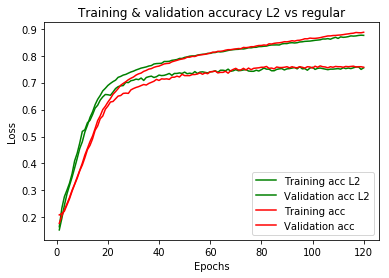

In [35]:
plt.clf()

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L2')
plt.plot(epochs, val_acc_values, 'g', label='Validation acc L2')
plt.plot(epochs, model_acc, 'r', label='Training acc')
plt.plot(epochs, model_val_acc, 'r', label='Validation acc')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of L2 regularization are quite disappointing here. We notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## 5.  L1 regularization

Let's have a look at L1 regularization. Will this work better?

In [36]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 105us/step - loss: 16.0605 - acc: 0.1540 - val_loss: 15.6270 - val_acc: 0.1810
Epoch 2/120
7500/7500 [==============================] - 0s 56us/step - loss: 15.2691 - acc: 0.2023 - val_loss: 14.8717 - val_acc: 0.2120
Epoch 3/120
7500/7500 [==============================] - 0s 56us/step - loss: 14.5292 - acc: 0.2252 - val_loss: 14.1472 - val_acc: 0.2300
Epoch 4/120
7500/7500 [==============================] - 0s 52us/step - loss: 13.8138 - acc: 0.2425 - val_loss: 13.4431 - val_acc: 0.2550
Epoch 5/120
7500/7500 [==============================] - 0s 59us/step - loss: 13.1181 - acc: 0.2583 - val_loss: 12.7578 - val_acc: 0.2840
Epoch 6/120
7500/7500 [==============================] - 0s 52us/step - loss: 12.4408 - acc: 0.2875 - val_loss: 12.0916 - val_acc: 0.3140
Epoch 7/120
7500/7500 [==============================] - 0s 56us/step - loss: 11.7817 - acc: 0.3204 - val_loss: 11.4437 - v

7500/7500 [==============================] - 0s 53us/step - loss: 1.7214 - acc: 0.7080 - val_loss: 1.7500 - val_acc: 0.6800
Epoch 61/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.7121 - acc: 0.7095 - val_loss: 1.7386 - val_acc: 0.6740
Epoch 62/120
7500/7500 [==============================] - 0s 50us/step - loss: 1.7029 - acc: 0.7085 - val_loss: 1.7327 - val_acc: 0.6820
Epoch 63/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.6940 - acc: 0.7104 - val_loss: 1.7226 - val_acc: 0.6810
Epoch 64/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.6853 - acc: 0.7077 - val_loss: 1.7158 - val_acc: 0.6840
Epoch 65/120
7500/7500 [==============================] - 0s 52us/step - loss: 1.6773 - acc: 0.7112 - val_loss: 1.7056 - val_acc: 0.6760
Epoch 66/120
7500/7500 [==============================] - 0s 51us/step - loss: 1.6686 - acc: 0.7092 - val_loss: 1.6956 - val_acc: 0.6800
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 47us/step - loss: 1.3371 - acc: 0.7347 - val_loss: 1.3764 - val_acc: 0.7070


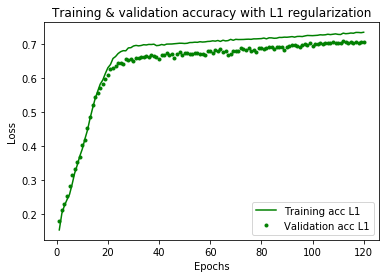

In [37]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g.', label='Validation acc L1')
plt.title('Training & validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how The training and validation accuracy don't diverge as much as before! Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like we can still improve the model by training much longer.

In [40]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/1000
7500/7500 [==============================] - 1s 92us/step - loss: 16.0066 - acc: 0.1613 - val_loss: 15.5993 - val_acc: 0.1770
Epoch 2/1000
7500/7500 [==============================] - 0s 57us/step - loss: 15.2411 - acc: 0.1965 - val_loss: 14.8512 - val_acc: 0.2020
Epoch 3/1000
7500/7500 [==============================] - 0s 59us/step - loss: 14.5038 - acc: 0.2159 - val_loss: 14.1278 - val_acc: 0.2230
Epoch 4/1000
7500/7500 [==============================] - 0s 53us/step - loss: 13.7885 - acc: 0.2317 - val_loss: 13.4244 - val_acc: 0.2320
Epoch 5/1000
7500/7500 [==============================] - 0s 55us/step - loss: 13.0932 - acc: 0.2477 - val_loss: 12.7406 - val_acc: 0.2600
Epoch 6/1000
7500/7500 [==============================] - 0s 56us/step - loss: 12.4165 - acc: 0.2695 - val_loss: 12.0748 - val_acc: 0.2730
Epoch 7/1000
7500/7500 [==============================] - 0s 53us/step - loss: 11.7564 - acc: 0.2987 - val_loss: 11.42

Epoch 60/1000
7500/7500 [==============================] - 0s 48us/step - loss: 1.7259 - acc: 0.7097 - val_loss: 1.7417 - val_acc: 0.6830
Epoch 61/1000
7500/7500 [==============================] - 0s 47us/step - loss: 1.7164 - acc: 0.7099 - val_loss: 1.7345 - val_acc: 0.6850
Epoch 62/1000
7500/7500 [==============================] - 0s 46us/step - loss: 1.7073 - acc: 0.7108 - val_loss: 1.7256 - val_acc: 0.6810
Epoch 63/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.6974 - acc: 0.7117 - val_loss: 1.7135 - val_acc: 0.6850
Epoch 64/1000
7500/7500 [==============================] - 0s 50us/step - loss: 1.6882 - acc: 0.7105 - val_loss: 1.7048 - val_acc: 0.6870
Epoch 65/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.6791 - acc: 0.7117 - val_loss: 1.6974 - val_acc: 0.6880
Epoch 66/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.6701 - acc: 0.7119 - val_loss: 1.6912 - val_acc: 0.6860
Epoch 67/1000
7500/7500 [=========

7500/7500 [==============================] - 0s 54us/step - loss: 1.3308 - acc: 0.7324 - val_loss: 1.3599 - val_acc: 0.6960
Epoch 120/1000
7500/7500 [==============================] - 0s 54us/step - loss: 1.3270 - acc: 0.7333 - val_loss: 1.3556 - val_acc: 0.6970
Epoch 121/1000
7500/7500 [==============================] - 0s 55us/step - loss: 1.3215 - acc: 0.7324 - val_loss: 1.3478 - val_acc: 0.7040
Epoch 122/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.3170 - acc: 0.7325 - val_loss: 1.3470 - val_acc: 0.7000
Epoch 123/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.3124 - acc: 0.7351 - val_loss: 1.3443 - val_acc: 0.7070
Epoch 124/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.3085 - acc: 0.7323 - val_loss: 1.3373 - val_acc: 0.7020
Epoch 125/1000
7500/7500 [==============================] - 0s 46us/step - loss: 1.3039 - acc: 0.7351 - val_loss: 1.3336 - val_acc: 0.6980
Epoch 126/1000
7500/7500 [================

Epoch 178/1000
7500/7500 [==============================] - 0s 50us/step - loss: 1.1317 - acc: 0.7483 - val_loss: 1.1684 - val_acc: 0.7150
Epoch 179/1000
7500/7500 [==============================] - 0s 47us/step - loss: 1.1296 - acc: 0.7487 - val_loss: 1.1729 - val_acc: 0.7120
Epoch 180/1000
7500/7500 [==============================] - 0s 50us/step - loss: 1.1278 - acc: 0.7496 - val_loss: 1.1674 - val_acc: 0.7110
Epoch 181/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.1265 - acc: 0.7499 - val_loss: 1.1664 - val_acc: 0.7140
Epoch 182/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.1234 - acc: 0.7493 - val_loss: 1.1686 - val_acc: 0.7130
Epoch 183/1000
7500/7500 [==============================] - 0s 49us/step - loss: 1.1224 - acc: 0.7503 - val_loss: 1.1610 - val_acc: 0.7120
Epoch 184/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.1193 - acc: 0.7513 - val_loss: 1.1623 - val_acc: 0.7140
Epoch 185/1000
7500/7500 [=

Epoch 237/1000
7500/7500 [==============================] - 1s 67us/step - loss: 1.0444 - acc: 0.7597 - val_loss: 1.0984 - val_acc: 0.7300
Epoch 238/1000
7500/7500 [==============================] - 0s 64us/step - loss: 1.0451 - acc: 0.7596 - val_loss: 1.0936 - val_acc: 0.7260
Epoch 239/1000
7500/7500 [==============================] - 0s 62us/step - loss: 1.0433 - acc: 0.7603 - val_loss: 1.0907 - val_acc: 0.7260
Epoch 240/1000
7500/7500 [==============================] - 0s 61us/step - loss: 1.0422 - acc: 0.7617 - val_loss: 1.0878 - val_acc: 0.7260
Epoch 241/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.0410 - acc: 0.7599 - val_loss: 1.1029 - val_acc: 0.7260
Epoch 242/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.0405 - acc: 0.7625 - val_loss: 1.0851 - val_acc: 0.7290
Epoch 243/1000
7500/7500 [==============================] - 0s 51us/step - loss: 1.0383 - acc: 0.7609 - val_loss: 1.0829 - val_acc: 0.7280
Epoch 244/1000
7500/7500 [=

Epoch 296/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9913 - acc: 0.7669 - val_loss: 1.0506 - val_acc: 0.7270
Epoch 297/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.9913 - acc: 0.7667 - val_loss: 1.0502 - val_acc: 0.7310
Epoch 298/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9895 - acc: 0.7667 - val_loss: 1.0454 - val_acc: 0.7360
Epoch 299/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.9885 - acc: 0.7679 - val_loss: 1.0458 - val_acc: 0.7370
Epoch 300/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.9879 - acc: 0.7695 - val_loss: 1.0473 - val_acc: 0.7310
Epoch 301/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.9874 - acc: 0.7679 - val_loss: 1.0427 - val_acc: 0.7340
Epoch 302/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9870 - acc: 0.7672 - val_loss: 1.0449 - val_acc: 0.7340
Epoch 303/1000
7500/7500 [=

Epoch 355/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.9537 - acc: 0.7729 - val_loss: 1.0184 - val_acc: 0.7390
Epoch 356/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9539 - acc: 0.7736 - val_loss: 1.0113 - val_acc: 0.7410
Epoch 357/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.9522 - acc: 0.7723 - val_loss: 1.0123 - val_acc: 0.7420
Epoch 358/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.9522 - acc: 0.7715 - val_loss: 1.0164 - val_acc: 0.7390
Epoch 359/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9512 - acc: 0.7740 - val_loss: 1.0110 - val_acc: 0.7410
Epoch 360/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.9514 - acc: 0.7719 - val_loss: 1.0094 - val_acc: 0.7440
Epoch 361/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.9494 - acc: 0.7751 - val_loss: 1.0129 - val_acc: 0.7420
Epoch 362/1000
7500/7500 [=

Epoch 414/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9252 - acc: 0.7779 - val_loss: 0.9923 - val_acc: 0.7470
Epoch 415/1000
7500/7500 [==============================] - 0s 45us/step - loss: 0.9244 - acc: 0.7792 - val_loss: 0.9999 - val_acc: 0.7420
Epoch 416/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.9249 - acc: 0.7787 - val_loss: 0.9894 - val_acc: 0.7500
Epoch 417/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.9240 - acc: 0.7784 - val_loss: 0.9911 - val_acc: 0.7450
Epoch 418/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9233 - acc: 0.7773 - val_loss: 1.0048 - val_acc: 0.7400
Epoch 419/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.9225 - acc: 0.7811 - val_loss: 0.9959 - val_acc: 0.7410
Epoch 420/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.9224 - acc: 0.7811 - val_loss: 0.9924 - val_acc: 0.7480
Epoch 421/1000
7500/7500 [=

Epoch 473/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9019 - acc: 0.7845 - val_loss: 0.9706 - val_acc: 0.7530
Epoch 474/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.9014 - acc: 0.7837 - val_loss: 1.0190 - val_acc: 0.7330
Epoch 475/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.9031 - acc: 0.7845 - val_loss: 0.9735 - val_acc: 0.7520
Epoch 476/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.9006 - acc: 0.7820 - val_loss: 0.9716 - val_acc: 0.7500
Epoch 477/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.9004 - acc: 0.7836 - val_loss: 0.9763 - val_acc: 0.7500
Epoch 478/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.9015 - acc: 0.7845 - val_loss: 0.9684 - val_acc: 0.7580
Epoch 479/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.9014 - acc: 0.7837 - val_loss: 0.9809 - val_acc: 0.7400
Epoch 480/1000
7500/7500 [=

Epoch 532/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8843 - acc: 0.7885 - val_loss: 0.9652 - val_acc: 0.7540
Epoch 533/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8843 - acc: 0.7861 - val_loss: 0.9957 - val_acc: 0.7320
Epoch 534/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.8856 - acc: 0.7872 - val_loss: 0.9570 - val_acc: 0.7570
Epoch 535/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8835 - acc: 0.7876 - val_loss: 0.9733 - val_acc: 0.7540
Epoch 536/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8845 - acc: 0.7871 - val_loss: 0.9594 - val_acc: 0.7620
Epoch 537/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8823 - acc: 0.7893 - val_loss: 0.9585 - val_acc: 0.7520
Epoch 538/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8820 - acc: 0.7884 - val_loss: 0.9685 - val_acc: 0.7550
Epoch 539/1000
7500/7500 [=

Epoch 591/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8691 - acc: 0.7925 - val_loss: 0.9495 - val_acc: 0.7600
Epoch 592/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8662 - acc: 0.7941 - val_loss: 0.9539 - val_acc: 0.7660
Epoch 593/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8669 - acc: 0.7947 - val_loss: 0.9538 - val_acc: 0.7550
Epoch 594/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8673 - acc: 0.7935 - val_loss: 0.9572 - val_acc: 0.7530
Epoch 595/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8663 - acc: 0.7920 - val_loss: 0.9488 - val_acc: 0.7630
Epoch 596/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8675 - acc: 0.7943 - val_loss: 0.9488 - val_acc: 0.7680
Epoch 597/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8656 - acc: 0.7941 - val_loss: 0.9641 - val_acc: 0.7500
Epoch 598/1000
7500/7500 [=

Epoch 650/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8552 - acc: 0.7959 - val_loss: 0.9542 - val_acc: 0.7540
Epoch 651/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8555 - acc: 0.7977 - val_loss: 0.9456 - val_acc: 0.7630
Epoch 652/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8526 - acc: 0.7969 - val_loss: 0.9543 - val_acc: 0.7500
Epoch 653/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8531 - acc: 0.7969 - val_loss: 0.9594 - val_acc: 0.7530
Epoch 654/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8534 - acc: 0.7964 - val_loss: 0.9630 - val_acc: 0.7500
Epoch 655/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8543 - acc: 0.7976 - val_loss: 0.9396 - val_acc: 0.7670
Epoch 656/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8529 - acc: 0.7960 - val_loss: 0.9358 - val_acc: 0.7620
Epoch 657/1000
7500/7500 [=

Epoch 709/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.8424 - acc: 0.7993 - val_loss: 0.9465 - val_acc: 0.7510
Epoch 710/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8412 - acc: 0.8008 - val_loss: 0.9352 - val_acc: 0.7590
Epoch 711/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8442 - acc: 0.8004 - val_loss: 0.9359 - val_acc: 0.7690
Epoch 712/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8419 - acc: 0.8036 - val_loss: 0.9329 - val_acc: 0.7620
Epoch 713/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8427 - acc: 0.8007 - val_loss: 0.9390 - val_acc: 0.7580
Epoch 714/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8419 - acc: 0.7995 - val_loss: 0.9504 - val_acc: 0.7510
Epoch 715/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8401 - acc: 0.8016 - val_loss: 0.9519 - val_acc: 0.7480
Epoch 716/1000
7500/7500 [=

Epoch 768/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8331 - acc: 0.8057 - val_loss: 0.9450 - val_acc: 0.7600
Epoch 769/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8303 - acc: 0.8055 - val_loss: 0.9359 - val_acc: 0.7630
Epoch 770/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8322 - acc: 0.8044 - val_loss: 0.9354 - val_acc: 0.7560
Epoch 771/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8296 - acc: 0.8045 - val_loss: 0.9565 - val_acc: 0.7460
Epoch 772/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8308 - acc: 0.8035 - val_loss: 0.9301 - val_acc: 0.7590
Epoch 773/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8315 - acc: 0.8043 - val_loss: 0.9800 - val_acc: 0.7460
Epoch 774/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8364 - acc: 0.8020 - val_loss: 0.9316 - val_acc: 0.7660
Epoch 775/1000
7500/7500 [=

Epoch 827/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8232 - acc: 0.8075 - val_loss: 0.9415 - val_acc: 0.7550
Epoch 828/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8236 - acc: 0.8071 - val_loss: 0.9249 - val_acc: 0.7670
Epoch 829/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.8225 - acc: 0.8073 - val_loss: 0.9325 - val_acc: 0.7580
Epoch 830/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8215 - acc: 0.8068 - val_loss: 0.9310 - val_acc: 0.7660
Epoch 831/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8220 - acc: 0.8103 - val_loss: 0.9332 - val_acc: 0.7620
Epoch 832/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8235 - acc: 0.8083 - val_loss: 0.9684 - val_acc: 0.7490
Epoch 833/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.8227 - acc: 0.8065 - val_loss: 0.9341 - val_acc: 0.7610
Epoch 834/1000
7500/7500 [=

Epoch 886/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8142 - acc: 0.8120 - val_loss: 0.9288 - val_acc: 0.7640
Epoch 887/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8144 - acc: 0.8124 - val_loss: 0.9498 - val_acc: 0.7560
Epoch 888/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8168 - acc: 0.8097 - val_loss: 0.9382 - val_acc: 0.7550
Epoch 889/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8160 - acc: 0.8092 - val_loss: 0.9308 - val_acc: 0.7700
Epoch 890/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8125 - acc: 0.8157 - val_loss: 0.9583 - val_acc: 0.7590
Epoch 891/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8123 - acc: 0.8135 - val_loss: 0.9955 - val_acc: 0.7340
Epoch 892/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8170 - acc: 0.8109 - val_loss: 0.9320 - val_acc: 0.7540
Epoch 893/1000
7500/7500 [=

Epoch 945/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8082 - acc: 0.8151 - val_loss: 0.9369 - val_acc: 0.7660
Epoch 946/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8091 - acc: 0.8139 - val_loss: 0.9720 - val_acc: 0.7580
Epoch 947/1000
7500/7500 [==============================] - 0s 48us/step - loss: 0.8128 - acc: 0.8157 - val_loss: 0.9230 - val_acc: 0.7730
Epoch 948/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.8065 - acc: 0.8153 - val_loss: 0.9318 - val_acc: 0.7610
Epoch 949/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8067 - acc: 0.8140 - val_loss: 0.9606 - val_acc: 0.7410
Epoch 950/1000
7500/7500 [==============================] - 0s 46us/step - loss: 0.8108 - acc: 0.8141 - val_loss: 0.9511 - val_acc: 0.7580
Epoch 951/1000
7500/7500 [==============================] - 0s 47us/step - loss: 0.8104 - acc: 0.8153 - val_loss: 0.9294 - val_acc: 0.7700
Epoch 952/1000
7500/7500 [=

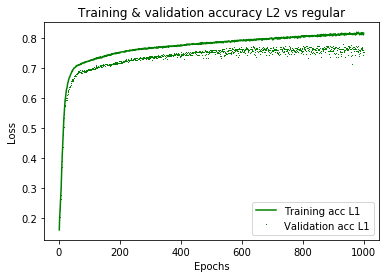

In [41]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g,', label='Validation acc L1')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
results_train = model.evaluate(train_final, label_train_final)

results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 89us/step


In [43]:
results_train

[0.8107994386672973, 0.8129333333333333]

In [44]:
results_test

[0.9627697960535685, 0.7500000003178915]

This is about the best we've seen so far, but we were training for quite a while! Let's see if dropout regularization can do even better and/or be more efficient!

## 6. dropout regularization

In [45]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(train_final,
                    label_train_final,
                    epochs=200,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 1s 147us/step - loss: 1.9692 - acc: 0.1484 - val_loss: 1.9299 - val_acc: 0.1830
Epoch 2/200
7500/7500 [==============================] - 1s 70us/step - loss: 1.9533 - acc: 0.1668 - val_loss: 1.9196 - val_acc: 0.2180
Epoch 3/200
7500/7500 [==============================] - 1s 74us/step - loss: 1.9370 - acc: 0.1835 - val_loss: 1.9120 - val_acc: 0.2290
Epoch 4/200
7500/7500 [==============================] - 1s 77us/step - loss: 1.9294 - acc: 0.1901 - val_loss: 1.9041 - val_acc: 0.2390
Epoch 5/200
7500/7500 [==============================] - 1s 84us/step - loss: 1.9199 - acc: 0.1969 - val_loss: 1.8944 - val_acc: 0.2570
Epoch 6/200
7500/7500 [==============================] - 1s 76us/step - loss: 1.9112 - acc: 0.2043 - val_loss: 1.8832 - val_acc: 0.2660
Epoch 7/200
7500/7500 [==============================] - 1s 71us/step - loss: 1.9029 - acc: 0.2148 - val_loss: 1.8726 - val_acc: 0.2850

7500/7500 [==============================] - 1s 71us/step - loss: 1.1663 - acc: 0.5741 - val_loss: 0.9342 - val_acc: 0.7080
Epoch 61/200
7500/7500 [==============================] - 1s 69us/step - loss: 1.1560 - acc: 0.5752 - val_loss: 0.9252 - val_acc: 0.7030
Epoch 62/200
7500/7500 [==============================] - 1s 73us/step - loss: 1.1598 - acc: 0.5759 - val_loss: 0.9195 - val_acc: 0.7080
Epoch 63/200
7500/7500 [==============================] - 0s 66us/step - loss: 1.1477 - acc: 0.5728 - val_loss: 0.9134 - val_acc: 0.7110
Epoch 64/200
7500/7500 [==============================] - 1s 67us/step - loss: 1.1382 - acc: 0.5820 - val_loss: 0.9075 - val_acc: 0.7060
Epoch 65/200
7500/7500 [==============================] - 0s 64us/step - loss: 1.1278 - acc: 0.5815 - val_loss: 0.9020 - val_acc: 0.7050
Epoch 66/200
7500/7500 [==============================] - 1s 69us/step - loss: 1.1210 - acc: 0.5893 - val_loss: 0.8935 - val_acc: 0.7070
Epoch 67/200
7500/7500 [==============================

Epoch 120/200
7500/7500 [==============================] - 1s 68us/step - loss: 0.8932 - acc: 0.6735 - val_loss: 0.7191 - val_acc: 0.7400
Epoch 121/200
7500/7500 [==============================] - 0s 66us/step - loss: 0.8817 - acc: 0.6749 - val_loss: 0.7156 - val_acc: 0.7380
Epoch 122/200
7500/7500 [==============================] - 1s 67us/step - loss: 0.8771 - acc: 0.6867 - val_loss: 0.7149 - val_acc: 0.7360
Epoch 123/200
7500/7500 [==============================] - 0s 66us/step - loss: 0.8799 - acc: 0.6777 - val_loss: 0.7114 - val_acc: 0.7380
Epoch 124/200
7500/7500 [==============================] - 1s 69us/step - loss: 0.8911 - acc: 0.6719 - val_loss: 0.7094 - val_acc: 0.7400
Epoch 125/200
7500/7500 [==============================] - 0s 65us/step - loss: 0.8695 - acc: 0.6899 - val_loss: 0.7076 - val_acc: 0.7400
Epoch 126/200
7500/7500 [==============================] - 1s 67us/step - loss: 0.8786 - acc: 0.6793 - val_loss: 0.7057 - val_acc: 0.7390
Epoch 127/200
7500/7500 [=========

7500/7500 [==============================] - 1s 78us/step - loss: 0.7720 - acc: 0.7153 - val_loss: 0.6502 - val_acc: 0.7560
Epoch 180/200
7500/7500 [==============================] - 1s 79us/step - loss: 0.7635 - acc: 0.7205 - val_loss: 0.6514 - val_acc: 0.7570
Epoch 181/200
7500/7500 [==============================] - 1s 72us/step - loss: 0.7740 - acc: 0.7185 - val_loss: 0.6506 - val_acc: 0.7560
Epoch 182/200
7500/7500 [==============================] - 1s 73us/step - loss: 0.7793 - acc: 0.7143 - val_loss: 0.6511 - val_acc: 0.7600
Epoch 183/200
7500/7500 [==============================] - 0s 66us/step - loss: 0.7656 - acc: 0.7168 - val_loss: 0.6504 - val_acc: 0.7570
Epoch 184/200
7500/7500 [==============================] - 1s 70us/step - loss: 0.7672 - acc: 0.7228 - val_loss: 0.6489 - val_acc: 0.7620
Epoch 185/200
7500/7500 [==============================] - 1s 69us/step - loss: 0.7542 - acc: 0.7200 - val_loss: 0.6480 - val_acc: 0.7590
Epoch 186/200
7500/7500 [=======================

In [46]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 58us/step


In [47]:
results_train

[0.4506092483997345, 0.8509333333651224]

In [48]:
results_test

[0.642771221001943, 0.7633333330154419]

You can see here that the validation performance has improved again! the variance did become higher again compared to L1-regularization.

## 7.  bigger data?

In the lecture, one of the solutions to high variance was just getting more data. We actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple our data set, and see what happens. Note that we are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [53]:
df = pd.read_csv('Bank_complaints.csv')
random.seed(123)
df = df.sample(40000)
df.index = range(40000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)
sequences = tokenizer.texts_to_sequences(complaints)
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

#one-hot encoding of products
le = preprocessing.LabelEncoder()
le.fit(product)
list(le.classes_)
product_cat = le.transform(product) 
product_onehot = to_categorical(product_cat)

# train test split
test_index = random.sample(range(1,40000), 4000)
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

#Validation set
random.seed(123)
val = train[:3000]
train_final = train[3000:]
label_val = label_train[:3000]
label_train_final = label_train[3000:]

In [58]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 33000 samples, validate on 3000 samples
Epoch 1/120
33000/33000 [==============================] - 4s 131us/step - loss: 1.9048 - acc: 0.2135 - val_loss: 1.8506 - val_acc: 0.2613
Epoch 2/120
33000/33000 [==============================] - 2s 50us/step - loss: 1.7545 - acc: 0.3381 - val_loss: 1.6589 - val_acc: 0.3933
Epoch 3/120
33000/33000 [==============================] - 2s 48us/step - loss: 1.5358 - acc: 0.4697 - val_loss: 1.4311 - val_acc: 0.5290
Epoch 4/120
33000/33000 [==============================] - 2s 49us/step - loss: 1.3184 - acc: 0.5745 - val_loss: 1.2332 - val_acc: 0.6100
Epoch 5/120
33000/33000 [==============================] - 2s 48us/step - loss: 1.1396 - acc: 0.6357 - val_loss: 1.0795 - val_acc: 0.6560
Epoch 6/120
33000/33000 [==============================] - 2s 49us/step - loss: 1.0041 - acc: 0.6733 - val_loss: 0.9654 - val_acc: 0.6867
Epoch 7/120
33000/33000 [==============================] - 2s 51us/step - loss: 0.9052 - acc: 0.6968 - val_loss: 0.8833 - 

33000/33000 [==============================] - 1s 45us/step - loss: 0.4034 - acc: 0.8571 - val_loss: 0.5365 - val_acc: 0.8060
Epoch 60/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.4009 - acc: 0.8576 - val_loss: 0.5357 - val_acc: 0.8050
Epoch 61/120
33000/33000 [==============================] - 2s 49us/step - loss: 0.3987 - acc: 0.8579 - val_loss: 0.5372 - val_acc: 0.8057
Epoch 62/120
33000/33000 [==============================] - 2s 46us/step - loss: 0.3964 - acc: 0.8595 - val_loss: 0.5337 - val_acc: 0.8060
Epoch 63/120
33000/33000 [==============================] - 2s 47us/step - loss: 0.3942 - acc: 0.8602 - val_loss: 0.5337 - val_acc: 0.8073
Epoch 64/120
33000/33000 [==============================] - 2s 46us/step - loss: 0.3918 - acc: 0.8607 - val_loss: 0.5330 - val_acc: 0.8070
Epoch 65/120
33000/33000 [==============================] - 2s 46us/step - loss: 0.3897 - acc: 0.8617 - val_loss: 0.5348 - val_acc: 0.8067
Epoch 66/120
33000/33000 [==============

Epoch 118/120
33000/33000 [==============================] - 2s 54us/step - loss: 0.3067 - acc: 0.8932 - val_loss: 0.5642 - val_acc: 0.8047
Epoch 119/120
33000/33000 [==============================] - 2s 53us/step - loss: 0.3056 - acc: 0.8937 - val_loss: 0.5648 - val_acc: 0.8050
Epoch 120/120
33000/33000 [==============================] - 2s 53us/step - loss: 0.3044 - acc: 0.8938 - val_loss: 0.5662 - val_acc: 0.8037


In [59]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

4000/4000 [==============================] - 0s 120us/step


In [60]:
results_train

[0.2989410331718849, 0.8967575757575758]

In [61]:
results_test

[0.5912333526611329, 0.80225]

With the same amount of epochs, we were able to get a fairly similar validation accuracy of 89.67 (compared to 88.55 in obtained in the first model in this lab). Our test set accuracy went up from 75.8 to a staggering 80.225% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## 8. Conclusion

## Sources

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database

## Further reading

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/